# Jupyter Notebook - Projet Banklytics
Ce projet s’appuie sur la méthodologie CRISP-ML, une adaptation moderne du standard CRISP-DM, spécifiquement conçue pour encadrer les projets de machine learning déployés en environnement réel. Cette approche intègre non seulement les étapes classiques de compréhension métier, de préparation des données, de modélisation et d’évaluation, mais elle met également l’accent sur les dimensions opérationnelles essentielles telles que le déploiement, le monitoring et la gouvernance du modèle. À chaque étape, les exigences métier, techniques et réglementaires ont été prises en compte. Le pipeline de traitement a été industrialisé à l’aide de Scikit-Learn, et l’optimisation des hyperparamètres a été confiée à Optuna afin d'assurer la robustesse et la performance du modèle en production. En intégrant les principes de CRISP-ML, ce projet garantit une solution alignée avec les bonnes pratiques de l’industrie, adaptée aux contraintes du secteur bancaire et pensée pour un déploiement durable et responsable.

## 1. Phase d’idéation : Business & Data Understanding

### Contexte métier
Banklytics est une banque nord-américaine active sur le marché des prêts hypothécaires. Dans un contexte de digitalisation croissante des services financiers, l’institution souhaite renforcer la rigueur de son processus d’évaluation immobilière. Actuellement, l’estimation de la valeur d’un bien proposé en garantie repose en partie sur le prix de vente déclaré par l’emprunteur et sur une expertise humaine, ce qui peut induire des biais ou des erreurs. Une surestimation expose la banque à un risque financier en cas de défaut, tandis qu’une sous-estimation peut nuire à l’expérience client et faire perdre des opportunités commerciales.

### Objectif du projet
Le projet vise à développer un modèle de régression supervisée permettant de prédire, à partir des caractéristiques objectives du bien, sa valeur de marché estimée. L’outil servira de référence neutre et reproductible pour les analystes d’octroi de crédit, dans le but de :

- Renforcer l’objectivité des décisions ;
- Réduire les écarts entre analystes ;
- Détecter plus rapidement les anomalies ;
- Accélérer le traitement des demandes standards.

Le modèle ne sera pas utilisé pour automatiser la décision, mais pour outiller l’expert humain.

### Origine et nature des données
Les données utilisées dans ce projet seront issues principalement des dossiers techniques de prêts hypothécaires déjà traités par Banklytics. Chaque dossier contiendra des informations structurées sur les biens immobiliers financés, telles que la surface habitable, le nombre de pièces, l’année de construction, l’état général, ou encore la présence d’annexes (garage, sous-sol, etc.), ainsi que la valeur d’expertise certifiée au moment de l’octroi du crédit.

Ces données internes seront nettoyées, anonymisées et consolidées afin de garantir la conformité aux exigences réglementaires (notamment en matière de protection des données personnelles) et de constituer un jeu d’apprentissage statistiquement fiable. Ce jeu sera ensuite enrichi par des données publiques ouvertes, telles que les registres cadastraux, les caractéristiques du quartier ou encore des indicateurs socio-économiques (revenu médian, densité de population), issus de sources officielles fiables.

L’ensemble constituera une base de données propriétaire de haute qualité, représentative du marché cible nord-américain. Cette approche permettra à la banque de disposer d’un socle de données robuste, légalement exploitable, et directement pertinent pour entraîner un modèle d’estimation fiable de la valeur immobilière.

### Critères de succès métier
Le projet est considéré comme réussi si :

- Réduction de 15 % des dossiers nécessitant une réévaluation manuelle en raison d’un écart trop important entre la valeur déclarée et la valeur estimée.
- Diminution du délai moyen de traitement des dossiers standards, avec un objectif de réduction de 20 % du temps d’analyse pour les cas non problématiques.
- Taux d’adoption de l’outil d’au moins 90 % par les analystes crédit dans les 6 mois suivant son déploiement.
- Amélioration de la transparence vis-à-vis des clients, via la capacité à justifier de manière claire et structurée les estimations immobilières produites par le modèle (traçabilité explicable).
- Augmentation du taux de satisfaction client mesuré par enquête post-octroi sur la clarté et la compréhension de la procédure d’évaluation.
- Réduction des prêts à risques et des pertes en cas de mauvais payeur

### Critère de succès techniques
Le Root Mean Squared Logarithmic Error (RMSLE) a été choisi comme unique indicateur de performance du modèle. Cette métrique présente plusieurs avantages particulièrement adaptés au contexte de l’évaluation de biens immobiliers dans le cadre de l’octroi de crédits hypothécaires.

Premièrement, le RMSLE évalue l’erreur relative entre la valeur prédite et la valeur réelle, ce qui est essentiel dans un domaine où les montants peuvent varier fortement d’un bien à l’autre. Une erreur de CHF 50'000 n’a pas le même poids si le bien est estimé à CHF 200’000 ou à CHF 1'500’000. Le RMSLE permet donc d’apprécier les écarts de manière proportionnelle.

Deuxièmement, la transformation logarithmique intégrée dans cette métrique réduit l’influence des outliers, en atténuant l’impact des valeurs extrêmes qui peuvent déséquilibrer les modèles traditionnels basés sur la RMSE.

Enfin, le RMSLE pénalise davantage les sous-estimations, ce qui est aligné avec une logique de prudence bancaire. Il est en effet préférable de sous-estimer légèrement la valeur d’un bien (ce qui limite le montant du prêt) que de le surévaluer, ce qui exposerait la banque à un risque de perte en cas de défaut.

Afin de valider un modèle techniquement, nous estimons que le RMSLE devrait être inférieur d'au moins 0.03 par rapport au score de la baseline que nous aurons identifié. L'investissement dans un modèle plus complexe que notre modèle baseline ne pourra pas être justifié le cas échéant.

### Qualité des données et risques identifiés
L’analyse exploratoire a permis d’identifier plusieurs enjeux de qualité :

Données manquantes sur certaines variables (ex. : surface du garage, année de rénovation) ;

Présence d’outliers extrêmes (ex. : biens de luxe) pouvant fausser la régression classique ;

Variables très asymétriques comme SalePrice, justifiant une transformation logarithmique pour la cible ;

Des techniques adaptées ont été intégrées au pipeline de traitement : imputation par médiane, transformation log1p, encodage One-Hot pour les variables catégorielles.

Variables clés identifiées
L’analyse exploratoire des corrélations et de la variance expliquée a permis de dégager les variables suivantes comme les plus prédictives :

GrLivArea (surface habitable en pieds carrés)

OverallQual (qualité générale perçue du bien)

YearBuilt (année de construction)

GarageArea (surface du garage)

Neighborhood (quartier)

Configuration de l'environnement et des différents imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge


import xgboost as xgb
import optuna

import mlflow
from mlflow.models import infer_signature
import joblib

import shap

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

Fonctions utilisées

In [4]:
# Display missing values
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

In [6]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))

## 1. Phase d'Idéation : Compréhension du Contexte et des Données

In [7]:
# 1.1 Chargement des données
try:
    train_df = pd.read_csv('train.csv', index_col = 'Id')
    test_df = pd.read_csv('test.csv', index_col = 'Id')
    print(f"Données d'entraînement chargées : {train_df.shape}")
    print(f"Données de test chargées : {test_df.shape}")
except FileNotFoundError:
    print("Erreur : Assurez-vous que les fichiers 'train.csv' et 'test.csv' sont présents.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()


Données d'entraînement chargées : (1460, 80)
Données de test chargées : (1459, 79)


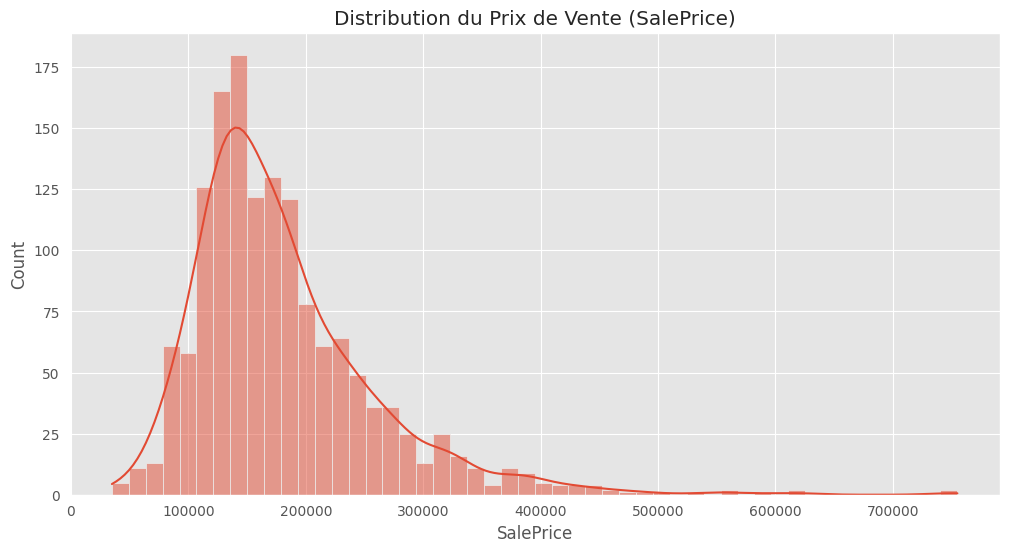

Asymétrie (Skewness) du prix de vente : 1.88
La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.


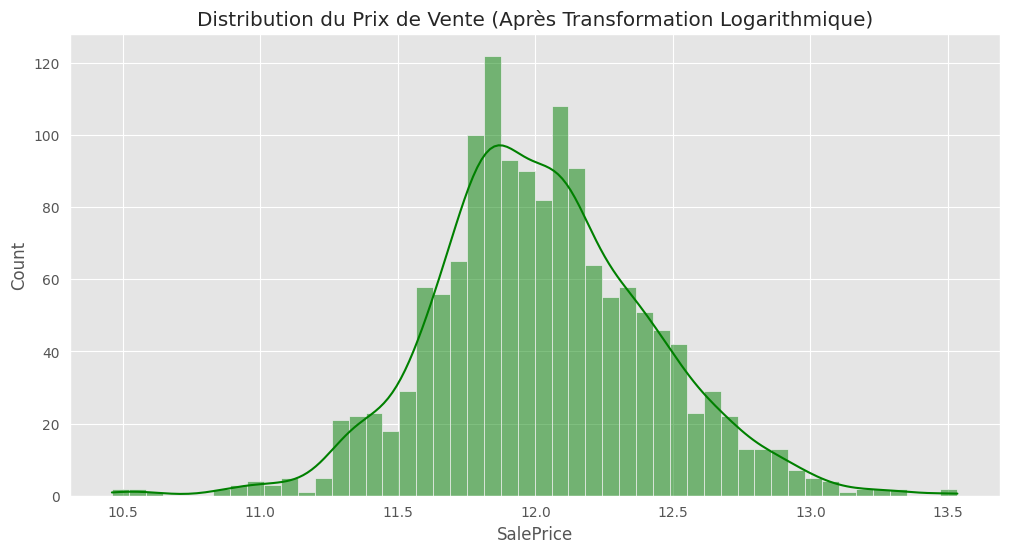

Asymétrie après transformation : 0.12


In [8]:
# 1.2 Analyse Exploratoire des Données (EDA)
if 'SalePrice' in train_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df['SalePrice'], kde=True, bins=50)
    plt.title('Distribution du Prix de Vente (SalePrice)')
    plt.show()
    print(f"Asymétrie (Skewness) du prix de vente : {train_df['SalePrice'].skew():.2f}")
    print("La distribution est fortement asymétrique à droite, justifiant une transformation logarithmique.")

    target = np.log1p(train_df["SalePrice"])

    plt.figure(figsize=(12, 6))
    sns.histplot(target, kde=True, bins=50, color='green')
    plt.title('Distribution du Prix de Vente (Après Transformation Logarithmique)')
    plt.show()
    print(f"Asymétrie après transformation : {target.skew():.2f}")

Nous allons donc toujours travailler avec notre target qui est le log(SalePrice). C'est pourquoi nous effectuerons nos comparaisons en RMSE afin de ne pas avoir de redondance avec le log déjà présent dans la target.

Il convient maintenant de nous intéresser de plus près aux données que nous avons à disposition afin de créer nos modèles. Nous allons dans un premier temps les diviser en trois catégories :
- Les données qualitatives
- Les données quantitatives
- Les dates



In [9]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

Une fois la catégorisation effectuée, nous avons controlé la qualité du dataset sur lequel nous allons entrainer nos modèles et certaines données sont manquantes ou alors non utilisables en l'état. Nous devons alors les nettoyer et les rendre utilisables par nos modèles. Afin de garder une cohérence, nous allons concaténer les données d'entrainements ainsi que les données de test pour être sur de traiter les données de la même manière.

Faisons dans un premier temps l'état des lieux des différentes valeurs que l'on pourrait qualifier de manquantes.

In [10]:
data_df = pd.concat([train_df, test_df])

Nombre de données quantitatives manquantes


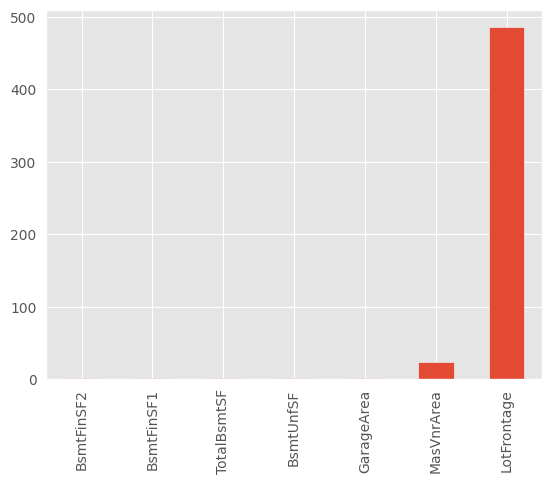

In [11]:
print(f"Nombre de données quantitatives manquantes")
plot_missing(data_df[quantitative])

Nombre de données qualitatives manquantes


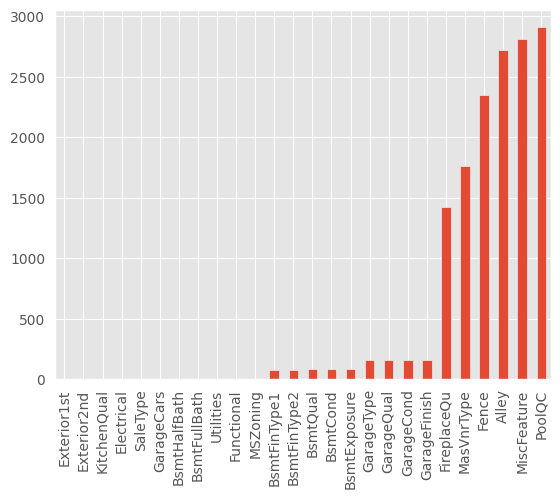

In [12]:
print(f"Nombre de données qualitatives manquantes")
plot_missing(data_df[qualitative])

Nombre de données dates manquantes


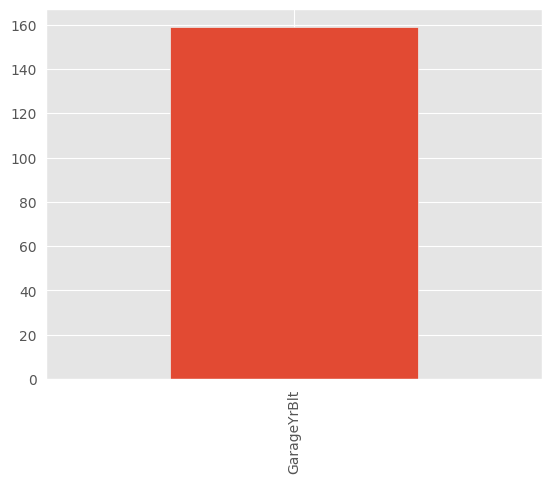

In [13]:
print(f"Nombre de données dates manquantes")
plot_missing(data_df[date])

Nous ne pouvons pas laisser ces données comme ça car elles seront inexploitable par le modèle. Par conséquent, en fonction du type de données nous allons devoir interpreter ce cela veut signifer. Par exemple, en ce qui concerne la donnée LotFrontage, NA signifie qu'il n'y a pas de rue collée à la propriété. Comme LotFrontage est une valeur quantitative, nous pouvons alors remplacé ce NA par 0 ce qui permettra au modèle de comprendre la donnée sans pour autant perdre l'information qu'elle représente.  
  
Certaines valeurs qualitatives comme GarageType ont également des données manquantes notées NA dans notre dataset cependant nous devons les traiter différemment puisqu'il s'agit de données qualitative. Nous avons décider de laisser NA pour toutes les données qualitatives et nous savons que cette notation n'indique pas l'absence de données (null) mais bien une information qui a été recensée.  
  
Concernant les colonnes de types date, seul GarageYrBlt contient des valeurs NA. Afin d'unifier cette donnée, nous avons décidé de remplacer par le valeur de l'année de construction

In [15]:
# Function to fill missing data with a constant value
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

In [16]:
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

Etant donné l'écart des années de ventes dans notre dataset, il nous faut convertir les différentes colonnes de dates (`YearBuilt`, `YearRemodAdd`, et `GarageYrBlt`) en durée afin d'unifier les durées entre l'année de vente et les différentes dates.

In [17]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [18]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [19]:
data_clean_df = clean(data_df)
train_clean_df = clean(train_df)
test_clean_df = clean(test_df)

## Modèle Baseline et choix des variables pour ce dernier  

Afin de pouvoir créer un modèle Baseline simple, nous devons séléctionner les variables qui vont être le plus correlées avec le logarithme du prix de vente.  
  
Pour se faire, nous devons encoder les variables qualitatives en variable numériques afin de calculer leur corrélation. Une solution à ce problème serait de remplacer la variable par la moyenne de la variable cible associée. Ceci entrainera donc une correlation entre la variable qualitative et la nouvelle variable créée.

In [20]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

In [21]:
#Function to calculate the correlation of Pearson between a target variable and features
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    cor['correlation_coef_abs'] = cor['correlation_coef'].abs()
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

,feature,correlation_coef,correlation_coef_abs
56,OverallQual,0.817185,0.817185
9,Neighborhood,0.755518,0.755518
66,GrLivArea,0.700927,0.700927
44,GarageCars,0.700078,0.700078
19,ExterQual,0.679060,0.679060
...,...,...,...
65,LowQualFinSF,-0.037963,0.037963
70,EnclosedPorch,-0.149050,0.149050
76,YearRemodAdd,-0.568136,0.568136
78,GarageYrBlt,-0.569568,0.569568


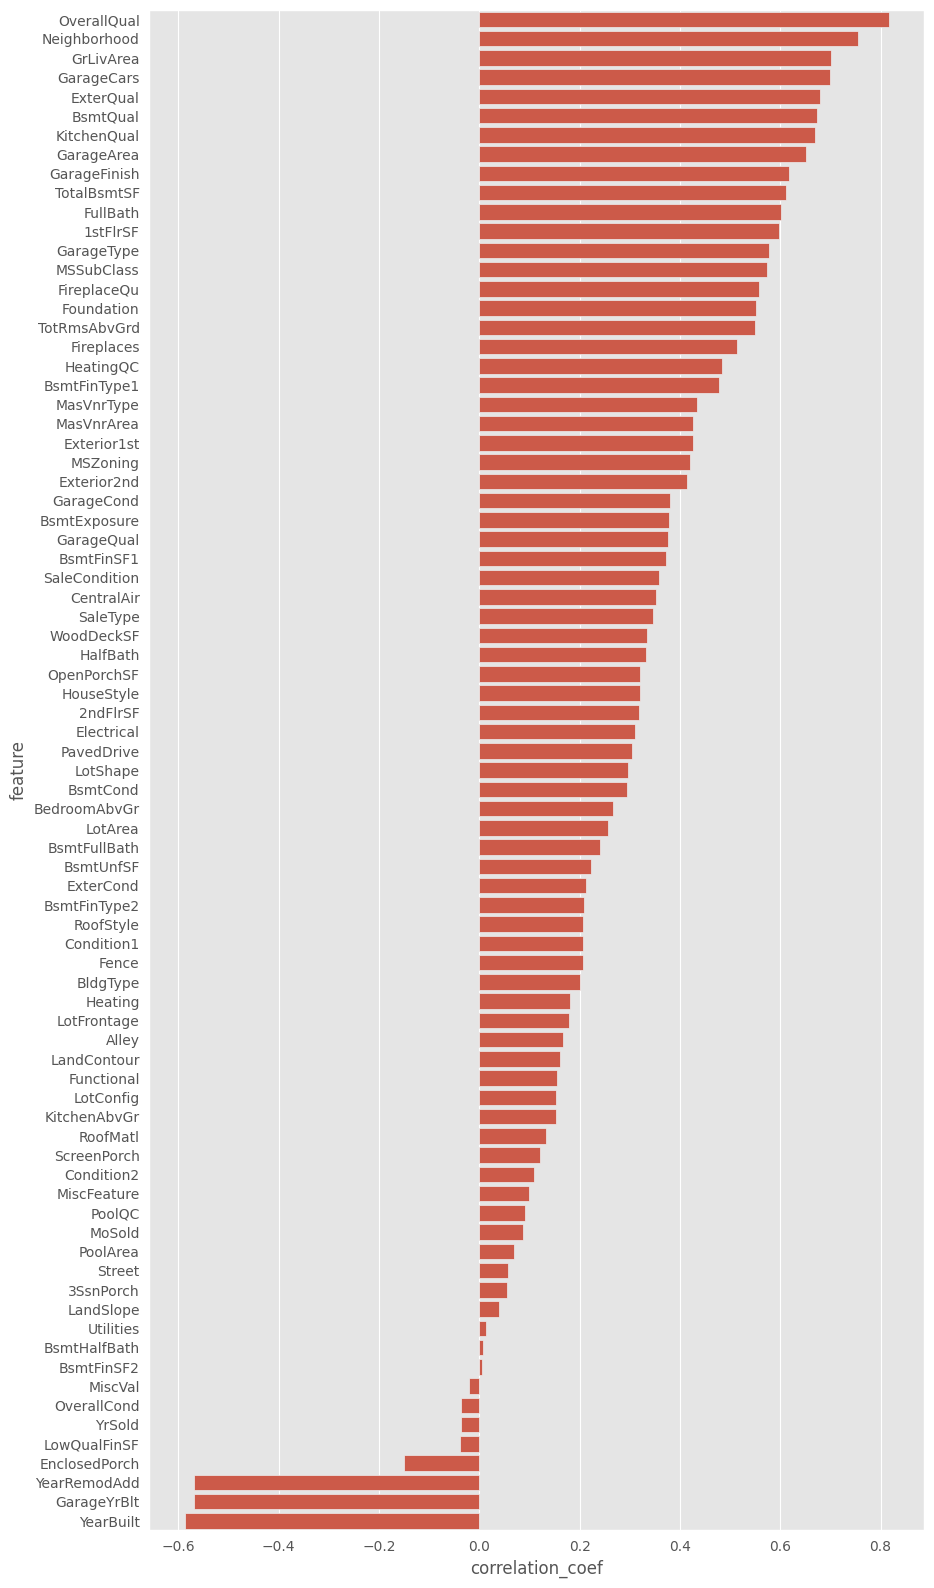

In [22]:
data_preprocess = encode_with_mean(data_clean_df, target, qualitative)

# Split of the clean dataset into train & validation
train_preprocess = data_preprocess[data_preprocess.index.isin(train_df.index)]
validation_preprocess = data_preprocess[data_preprocess.index.isin(test_df.index)]

cor = correlation(target, train_preprocess, qualitative + quantitative + date)
cor

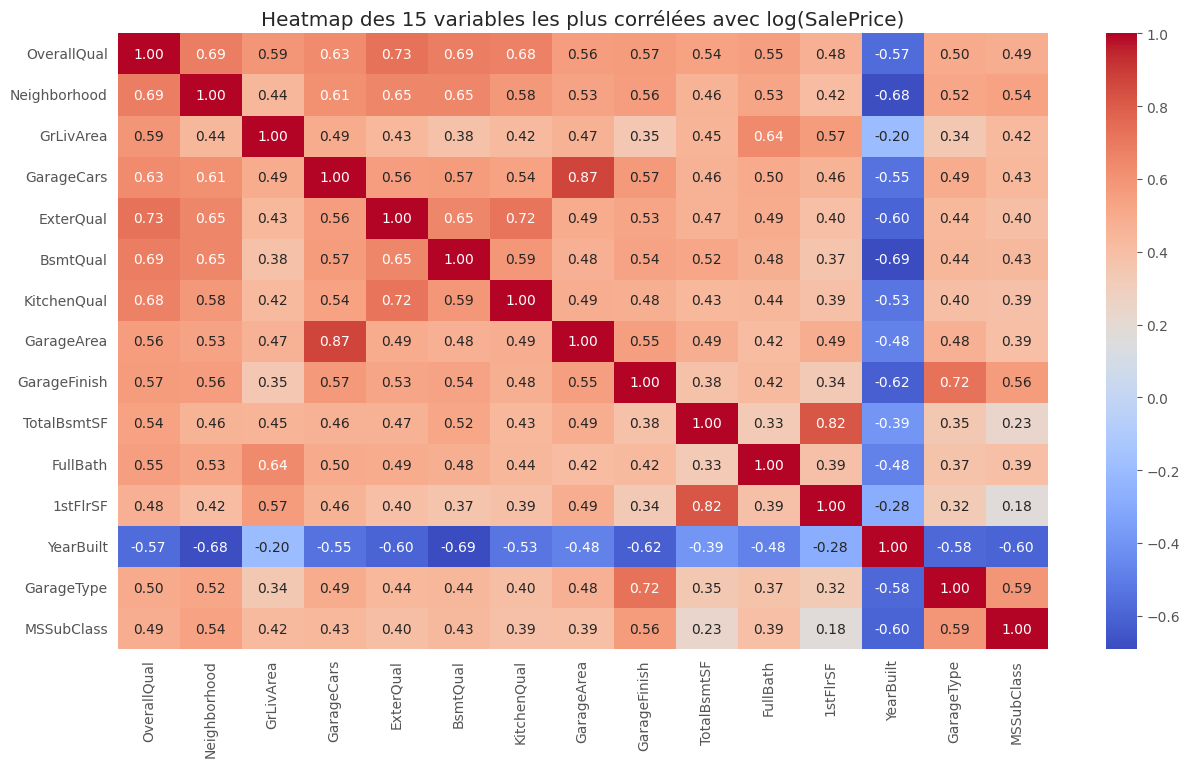

In [23]:
# Sélectionne les 10 variables avec la plus forte corrélation absolue
top15 = cor.sort_values('correlation_coef_abs', ascending=False).head(15)['feature'].tolist()
# Sous-ensemble du DataFrame train_preprocess avec ces variables
df_top10 = train_preprocess[top15]

# Affiche la heatmap de corrélation
plt.figure(figsize=(15, 8))
sns.heatmap(df_top10.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap des 15 variables les plus corrélées avec log(SalePrice)")
plt.show()

Nous allons donc séléctionner cinq variables afin de créer notre baseline. D'après les données de correlations ci-dessus ainsi que notre compréhension du métier et du domaine immobilier, les variables suivantes ont retenues notre attention.  
- `OverallQual`, correlation de 0.82
- `Neighborhood`, correlation de 0.76
- `GrLivArea`, correlation de 0.70
- `TotalBsmtSF`, correlation de 0.61
- `YearBuilt`, correlation de -0.59

Ces variables sont assez communes lors de la recherche d'un logement et représentent plus ou moins les critères de bases. En ce qui concerne la cave, il s'agit d'un point assez essentiel au vu de la situation géographique de Ames car elle se situe en plein milieu du couloir des tornades (zone géographique des États-Unis fréquemment touchée par ce phénomène).
  
Notre baseline reposera donc sur ces cinq variables et nous appliqueronns la regréssion linéaire afin de faire notre modèle.

In [24]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']


X = train_preprocess[base]
x_test = validation_preprocess[base]
y = target


model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:03:21   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

Voici les assomptions pour la régression linéaire, en indiquant avec quel graphique nous allons les tester :
- Linéarité de la relation entre les variables explicatives et la variable cible -> Residuals vs Fitted
- Les résultats sont normalements distribués autour de 0 -> Normal Q-Q Plot
- Homoscédasticité des résidus (variance constante) -> Scale-Location Plot
- Absence de points influents démesurés -> Residuals vs Leverage
- Absence d'outliers dans les résidus (erreurs extrêmes) -> visible dans plusieurs graphes, notamment Q-Q Plot et Cook’s Distance

In [25]:
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]))
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]))
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]))
    
    plot_lm_4 = plt.figure()
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]))
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right')

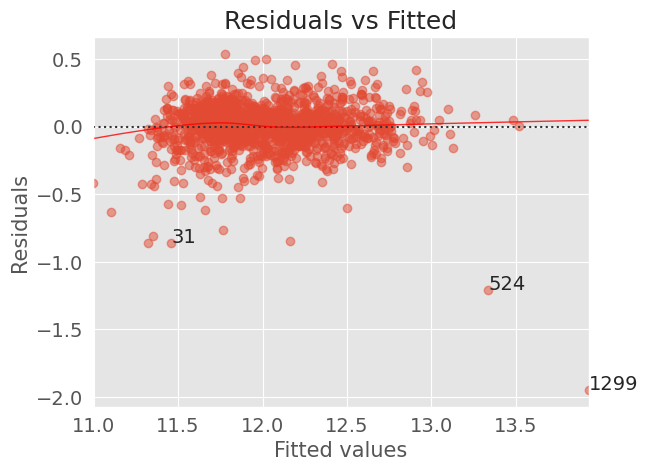

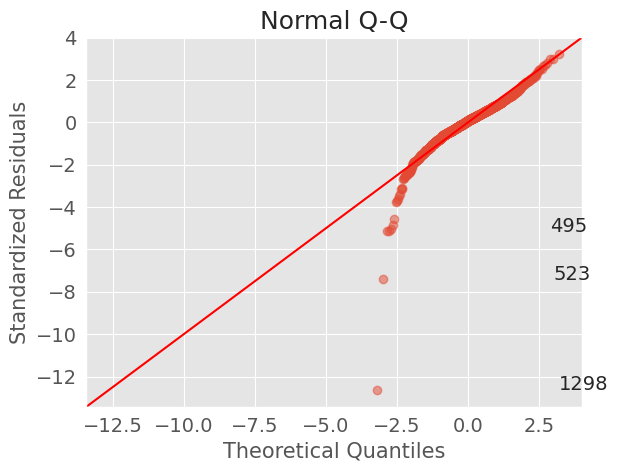

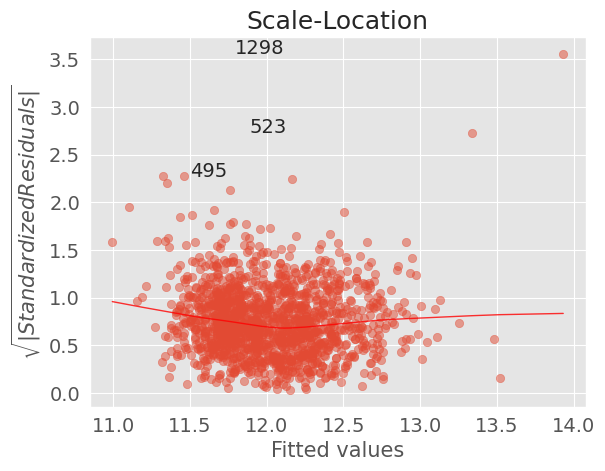

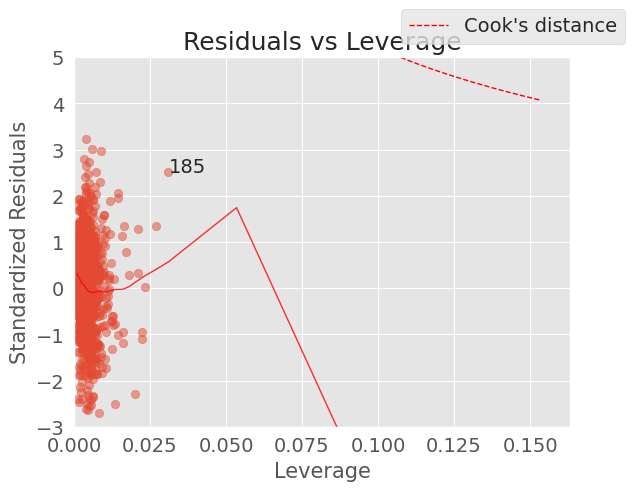

In [26]:
diagnostic_plots(sm.add_constant(X), y)

Nous voyons qu'il existe quelques valeurs extrêmes que les graphes ci-dessus ont mis en lumière. Il convient de les traiter afin qu'ils ne pejorent pas notre modèle. Un des critères sur lequel se baser pour éliminer une partie des ces valeurs extrêmes est la taille de la maison. En effet, par convention, les biens ayant une superficie habitable de plus de 4000 pieds carré sont extrêmement rares et ne sont pas représentatifs du marché.

Nous supprimons donc ces données extrêmes.

In [27]:
print(train_df[base].iloc[[31, 185, 495, 523, 524, 1298, 1299]])

      OverallQual Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
Id                                                               
32              5       Sawyer       1228         1228       1966
186            10      OldTown       3608         1107       1892
496             4       IDOTRR        720          720       1920
524            10      Edwards       4676         3138       2007
525             7      NoRidge       2398         1379       1996
1299           10      Edwards       5642         6110       2008
1300            5        NAmes       1246         1246       1959


In [28]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1522.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:04:13   Log-Likelihood:                 659.93
No. Observations:                1429   AIC:                            -1308.
Df Residuals:                    1423   BIC:                            -1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.7556      0.257     30.195   

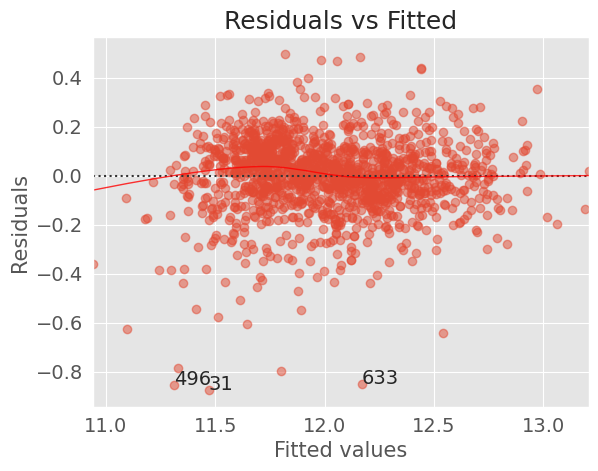

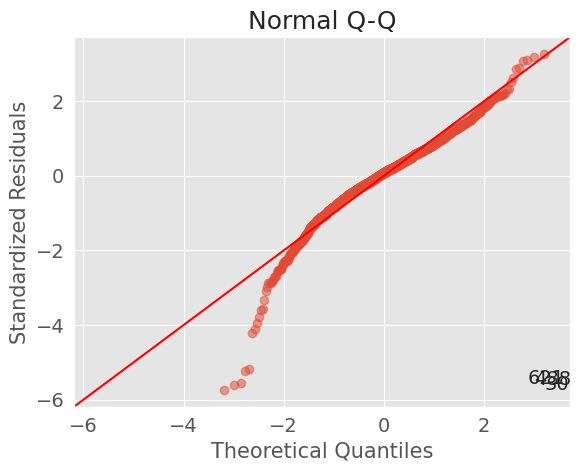

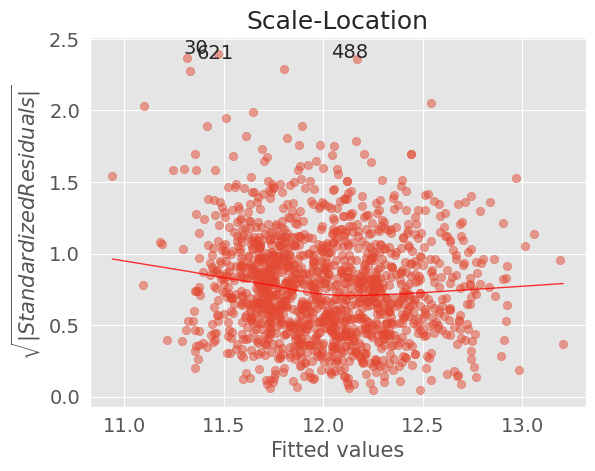

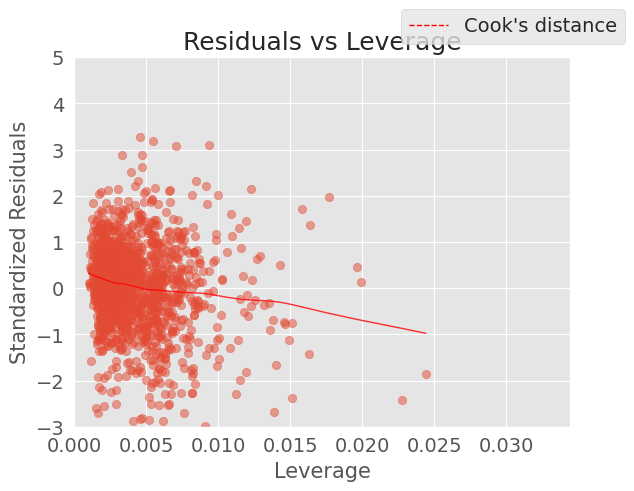

In [29]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

Notre modèle semble mieux se comporter sans ces valeurs extrêmes. Il semble être convaincant pour notre baseline. Nous allons donc calculer le RMSE basé sur notre target (le log de SalePrice)

In [30]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.214534
2    12.081588
3    12.244451
4    12.046219
5    12.620316
dtype: float64


In [31]:
baseline_RMSE = rmse(y, y_pred)
print('Root Mean Square Error (RMSE) :', baseline_RMSE)


Root Mean Square Error (RMSE) : 0.1524750806291098


In [32]:
y_pred_test = res.predict(sm.add_constant(x_test))

In [33]:
submission = pd.DataFrame()
submission['Id'] = y_pred_test.index
submission['SalePrice'] = np.expm1(y_pred_test.values)

submission.to_csv('Data/baselineV2.csv', index = False)

## 2. Phase de Design : Data & Model Engineering

In [34]:
# Séparation des features (X) et de la cible (y)
if 'SalePrice' in train_df.columns:
    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']
    X_test = test_df.copy()

# Ingénierie des Features
all_data = pd.concat([X, X_test], axis=0)


X = all_data.iloc[:len(y)]
X_test = all_data.iloc[len(y):]

Afin de s'assurer que nos données puissent être comprises et utilisées par notre modèle, il est primordial de créer une pipeline capable d'effectuer les transformations nécessaires de manières justes et systématiques.  

Dans notre cas, nous avons identifié trois types de données différents, les données quantitatives, les données qualitatives et les dates ou données temporelles. Il nous faudra donc créer des ColumnTransformer pour chacune de ces trois catégories.  

Il nous faudra également s'assurer de la qualité de nos données et ainsi "combler" les valeurs manquantes.
- Pour les valeurs quantitative, nous avons utilisé la stratégie de la médiane
- Pour les valeurs qualitative, nous avons utilisé la stratégie dite "Most frequent"

Enfin, il nous a fallu gérer les valeurs extrêmes, liées à GrLivArea, pour ça nous allons donc retiré les valeurs à l'aide de la fonction défini plus haut

In [35]:
#Pipeline de prétraitement
#Gestion des dates, transformation en durées relatives
def compute_relative_dates(df):
    df = df.copy()
    df['YearsSinceBuilt'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['YearsSinceGarage'] = df['YrSold'] - df['GarageYrBlt'].fillna(df['YearBuilt'])
    return df[['YearsSinceBuilt', 'YearsSinceRemod', 'YearsSinceGarage']]

date_transformer = Pipeline(steps=[
    ('relativedates', FunctionTransformer(compute_relative_dates, validate=False))
])

#Gestion des valeurs qunantitatives manquantes (median)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

#Gestion des valeurs qualitatives manquantes (most_frequent) et encodage one-hot

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Assemblage des transformations dans un préprocesseur

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, quantitative),
    ('cat', categorical_transformer, qualitative),
    ('dates', date_transformer, date)
], remainder='drop')

X_train = train_df.copy()
X_test = test_df.copy()
y_train = target.copy()

#Suppression des valeurs extrêmes

outliers_ids = train_df.index[(train_df['GrLivArea'] > 4000)]

X_train = X_train.drop(index=outliers_ids)
y_train = y_train.drop(index=outliers_ids)

#Pipeline finale

preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

preprocessing_pipeline

print(f"Nombre d'observations avant suppression des outliers : {train_df.shape[0]}")
print(f"Nombre d'observations après suppression : {X_train.shape[0]}")
print(f"Outliers supprimés : {len(outliers_ids)}")

Nombre d'observations avant suppression des outliers : 1460
Nombre d'observations après suppression : 1456
Outliers supprimés : 4


Nous ne sommes penchés sur trois modèles afin de les comparer :
- Random Forest
- Ridge Regression
- XGBoost

In [36]:
def random_forest_objective(trial, preprocessing_pipeline, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),
        'max_depth': trial.suggest_int('max_depth', 10, 40, log=True),
        'min_samples_split': trial.suggest_float('min_samples_split', 1e-5, 0.01, log=True),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 1e-6, 1e-4, log=True),
        'max_features': trial.suggest_float('max_features', 0.1, 0.8)
    }
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    return -score


def ridge_objective(trial, preprocessing_pipeline, X, y):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sag", "saga"]),
        "random_state": 42,
    }
    model = Ridge(**params)
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    return -score

def xgBoost_objective(trial, preprocessing_pipeline, X, y):
    params = {
        "eta": trial.suggest_float("eta", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "alpha": trial.suggest_float("alpha", 1e-6, 10, log=True),
        "lambda": trial.suggest_float("lambda", 1e-6, 10, log=True),
        "random_state": 42,
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", **params)
    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    return -score


In [37]:
def optimize_models(models_dict, X, y, preprocessing_pipeline, n_trials=40):
    """
    Optimise plusieurs modèles avec Optuna.
    Args:
        models_dict: dict, clé = nom du modèle, valeur = fonction objective(trial)
        n_trials: nombre d'essais Optuna par modèle
        X, y : données d'entraînement
        preprocessing_pipeline: Pipeline de prétraitement des données
    Returns:
        results: dict, clé = nom du modèle, valeur = (best_score, best_params, study)
    """

    results = {}
    for name, objective in models_dict.items():
        print(f"\n--- Optimisation {name} ---")

        def wrapped_objective(trial):
            return objective(trial, preprocessing_pipeline, X, y)
        
        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42), study_name=name)
        study.optimize(wrapped_objective, n_trials=n_trials, show_progress_bar=True)
        print(f"Meilleur score {name}: {study.best_value:.5f}")
        print("Meilleurs hyperparamètres:", study.best_params)
        results[name] = (study.best_value, study.best_params, study)


    names = list(results.keys())
    means = [results[name][0] for name in names]

    plt.figure(figsize=(10, 5))
    plt.bar(names, means, color='skyblue')
    plt.ylabel("Meilleur RMSE (CV)")
    plt.title("Comparaison des modèles optimisés")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return results

[I 2025-06-26 20:05:10,574] A new study created in memory with name: Random Forest



--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---

--- Optimisation Random Forest ---


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-26 20:05:12,709] Trial 0 finished with value: 0.13278986623904893 and parameters: {'n_estimators': 762, 'max_depth': 38, 'min_samples_split': 0.001570297088405539, 'min_samples_leaf': 1.575132049977973e-05, 'max_features': 0.20921304830970558}. Best is trial 0 with value: 0.13278986623904893.
[I 2025-06-26 20:05:14,793] Trial 1 finished with value: 0.13472544326096658 and parameters: {'n_estimators': 609, 'max_depth': 10, 'min_samples_split': 0.003967605077052989, 'min_samples_leaf': 1.5930522616241016e-05, 'max_features': 0.5956508044572318}. Best is trial 0 with value: 0.13278986623904893.
[I 2025-06-26 20:05:16,093] Trial 2 finished with value: 0.13267828692054592 and parameters: {'n_estimators': 514, 'max_depth': 39, 'min_samples_split': 0.00314288089084011, 'min_samples_leaf': 2.6587543983272713e-06, 'max_features': 0.22727747704497045}. Best is trial 2 with value: 0.13267828692054592.
[I 2025-06-26 20:05:17,963] Trial 3 finished with value: 0.13234873802611138 and para

[I 2025-06-26 20:10:26,750] A new study created in memory with name: Ridge


[I 2025-06-26 20:10:26,748] Trial 99 finished with value: 0.13228000334367676 and parameters: {'n_estimators': 1162, 'max_depth': 34, 'min_samples_split': 4.137609522379255e-05, 'min_samples_leaf': 5.483419802063973e-05, 'max_features': 0.3824584172237}. Best is trial 97 with value: 0.13183986022507527.
Meilleur score Random Forest: 0.13184
Meilleurs hyperparamètres: {'n_estimators': 1185, 'max_depth': 29, 'min_samples_split': 3.2445346640254876e-05, 'min_samples_leaf': 5.289286723616138e-05, 'max_features': 0.3761685147638135}

--- Optimisation Ridge ---


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-26 20:10:26,818] Trial 0 finished with value: 0.1291918378288153 and parameters: {'alpha': 0.03148911647956861, 'solver': 'auto'}. Best is trial 0 with value: 0.1291918378288153.
[I 2025-06-26 20:10:26,883] Trial 1 finished with value: 0.11692483159729909 and parameters: {'alpha': 2.9154431891537547, 'solver': 'lsqr'}. Best is trial 1 with value: 0.11692483159729909.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:29,114] Trial 2 finished with value: 0.29023866843844903 and parameters: {'alpha': 0.005337032762603957, 'solver': 'saga'}. Best is trial 1 with value: 0.11692483159729909.
[I 2025-06-26 20:10:29,170] Trial 3 finished with value: 0.11739928625643552 and parameters: {'alpha': 0.003613894271216527, 'solver': 'lsqr'}. Best is trial 1 with value: 0.11692483159729909.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:31,359] Trial 4 finished with value: 0.29023867093550487 and parameters: {'alpha': 0.23423849847112907, 'solver': 'saga'}. Best is trial 1 with value: 0.11692483159729909.
[I 2025-06-26 20:10:31,425] Trial 5 finished with value: 0.11807470548982504 and parameters: {'alpha': 1.7123375973163988, 'solver': 'cholesky'}. Best is trial 1 with value: 0.11692483159729909.
[I 2025-06-26 20:10:31,481] Trial 6 finished with value: 0.130700159980436 and parameters: {'alpha': 0.0013726318898045872, 'solver': 'auto'}. Best is trial 1 with value: 0.11692483159729909.
[I 2025-06-26 20:10:31,536] Trial 7 finished with value: 0.13044486059647403 and parameters: {'alpha': 0.0054880470007660455, 'solver': 'auto'}. Best is trial 1 with value: 0.11692483159729909.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:33,766] Trial 8 finished with value: 0.29023866840516455 and parameters: {'alpha': 0.002259279742015696, 'solver': 'saga'}. Best is trial 1 with value: 0.11692483159729909.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:36,046] Trial 9 finished with value: 0.29023866867219206 and parameters: {'alpha': 0.026730883107816707, 'solver': 'saga'}. Best is trial 1 with value: 0.11692483159729909.
[I 2025-06-26 20:10:36,105] Trial 10 finished with value: 0.11632704070932587 and parameters: {'alpha': 8.229631658321765, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11632704070932587.
[I 2025-06-26 20:10:36,162] Trial 11 finished with value: 0.11638823551283473 and parameters: {'alpha': 7.553503645583182, 'solver': 'lsqr'}. Best is trial 10 with value: 0.11632704070932587.
[I 2025-06-26 20:10:36,221] Trial 12 finished with value: 0.11624539531735958 and parameters: {'alpha': 9.200548896897677, 'solver': 'lsqr'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:36,298] Trial 13 finished with value: 0.12130459096471029 and parameters: {'alpha': 0.6784934755125653, 'solver': 'svd'}. Best is trial 12 with value: 0.11624539531735958.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:38,119] Trial 14 finished with value: 0.28719301429115174 and parameters: {'alpha': 7.599302182701055, 'solver': 'sag'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:38,178] Trial 15 finished with value: 0.11726538764783796 and parameters: {'alpha': 0.7473456802129241, 'solver': 'lsqr'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:38,236] Trial 16 finished with value: 0.11736187879162681 and parameters: {'alpha': 0.20608126653638728, 'solver': 'lsqr'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:38,313] Trial 17 finished with value: 0.11671775798056878 and parameters: {'alpha': 2.7327692409935254, 'solver': 'svd'}. Best is trial 12 with value: 0.11624539531735958.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:40,142] Trial 18 finished with value: 0.28719305739183626 and parameters: {'alpha': 9.559762705602648, 'solver': 'sag'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:40,200] Trial 19 finished with value: 0.12016898136997431 and parameters: {'alpha': 0.9277209557387602, 'solver': 'cholesky'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:40,257] Trial 20 finished with value: 0.11738612650819998 and parameters: {'alpha': 0.07438905383410487, 'solver': 'lsqr'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:40,317] Trial 21 finished with value: 0.11666597506567289 and parameters: {'alpha': 4.913523172887011, 'solver': 'lsqr'}. Best is trial 12 with value: 0.11624539531735958.
[I 2025-06-26 20:10:40,374] Trial 22 finished with value: 0.116230649864037 and parameters: {'alpha': 9.385286252608193, 'solver': 'lsqr'}. Best is trial 22 with value: 0.116230649864037.
[I 2025-06-26 20:10:40,433] Trial 23 f

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:44,863] Trial 57 finished with value: 0.290238745806878 and parameters: {'alpha': 7.097729587431437, 'solver': 'saga'}. Best is trial 53 with value: 0.11476507734839529.
[I 2025-06-26 20:10:44,921] Trial 58 finished with value: 0.1165535327415534 and parameters: {'alpha': 2.9128776066663034, 'solver': 'auto'}. Best is trial 53 with value: 0.11476507734839529.
[I 2025-06-26 20:10:44,979] Trial 59 finished with value: 0.11488498011164625 and parameters: {'alpha': 6.86397158633385, 'solver': 'cholesky'}. Best is trial 53 with value: 0.11476507734839529.
[I 2025-06-26 20:10:45,037] Trial 60 finished with value: 0.11454684792496324 and parameters: {'alpha': 9.160857217239037, 'solver': 'cholesky'}. Best is trial 60 with value: 0.11454684792496324.
[I 2025-06-26 20:10:45,096] Trial 61 finished with value: 0.11467436591557238 and parameters: {'alpha': 8.122075614113182, 'solver': 'cholesky'}. Best is trial 60 with value: 0.11454684792496324.
[I 2025-06-26 20:10:45,153] Tri

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:47,925] Trial 79 finished with value: 0.28719293357668035 and parameters: {'alpha': 3.9279754935279287, 'solver': 'sag'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:47,984] Trial 80 finished with value: 0.11771017860522211 and parameters: {'alpha': 1.9255430397551057, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:48,043] Trial 81 finished with value: 0.11453179108085494 and parameters: {'alpha': 9.304279865566329, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:48,102] Trial 82 finished with value: 0.11450755004690157 and parameters: {'alpha': 9.54687935674304, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:48,160] Trial 83 finished with value: 0.11678484228430697 and parameters: {'alpha': 2.6639873247677026, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:48,

/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:50,657] Trial 89 finished with value: 0.29023870621878356 and parameters: {'alpha': 3.468710665344211, 'solver': 'saga'}. Best is trial 65 with value: 0.11446780210349258.


/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/bastien/lab/he-arc/House_Prices/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

[I 2025-06-26 20:10:52,487] Trial 90 finished with value: 0.2871930140570919 and parameters: {'alpha': 7.5886612440356584, 'solver': 'sag'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:52,546] Trial 91 finished with value: 0.11447791032426125 and parameters: {'alpha': 9.865533884503586, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:52,604] Trial 92 finished with value: 0.11447300038517545 and parameters: {'alpha': 9.92091505108881, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:52,663] Trial 93 finished with value: 0.1151844036317347 and parameters: {'alpha': 5.620410193296066, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:52,720] Trial 94 finished with value: 0.11473400896062518 and parameters: {'alpha': 7.719496014967118, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:52,779]

[I 2025-06-26 20:10:53,016] A new study created in memory with name: XGBoost


[I 2025-06-26 20:10:52,954] Trial 98 finished with value: 0.13023865476832386 and parameters: {'alpha': 0.00907330211440506, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
[I 2025-06-26 20:10:53,014] Trial 99 finished with value: 0.11470357170087457 and parameters: {'alpha': 7.919485779819003, 'solver': 'cholesky'}. Best is trial 65 with value: 0.11446780210349258.
Meilleur score Ridge: 0.11447
Meilleurs hyperparamètres: {'alpha': 9.980413478934727, 'solver': 'cholesky'}

--- Optimisation XGBoost ---


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-26 20:10:53,326] Trial 0 finished with value: 0.12263191692998084 and parameters: {'eta': 0.08116262258099886, 'n_estimators': 893, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.02904180608409973, 'alpha': 1.156732719914599, 'lambda': 0.016136341713591334}. Best is trial 0 with value: 0.12263191692998084.
[I 2025-06-26 20:10:53,444] Trial 1 finished with value: 0.12429677649290535 and parameters: {'eta': 0.14453378978124864, 'n_estimators': 104, 'max_depth': 19, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.09170225492671691, 'alpha': 0.000134801802908908, 'lambda': 0.004712973756110786}. Best is trial 0 with value: 0.12263191692998084.
[I 2025-06-26 20:10:53,581] Trial 2 finished with value: 0.12842711311300947 and parameters: {'eta': 0.092069553542002, 'n_estimators': 195, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6460723242

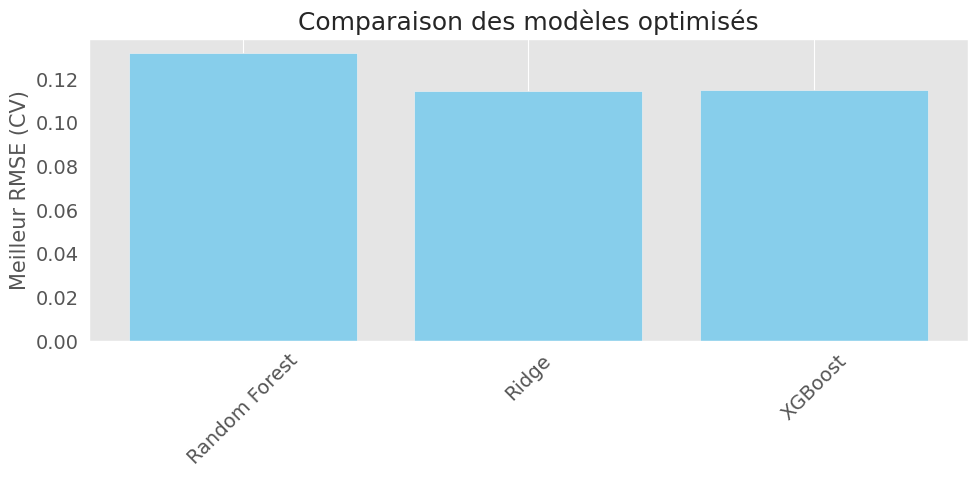

In [38]:
print("\n--- Démarrage de l'optimisation des hyperparamètres avec Optuna ---")

model_configs = {
    'Random Forest': random_forest_objective,
    'Ridge': ridge_objective,
    'XGBoost': xgBoost_objective
}

results = optimize_models(model_configs, X_train, y_train, preprocessing_pipeline, n_trials=100)

random_forest_best_params = results['Random Forest'][1]
ridge_best_params = results['Ridge'][1]
xgboost_best_params = results['XGBoost'][1]

random_forest_study = results['Random Forest'][2]
ridge_study = results['Ridge'][2]
xgboost_study = results['XGBoost'][2]


Afin de garder une trace des meilleurs hyper-paramètres, nous allons loggé nos meilleurs modèles dans MLFlow

In [40]:
# Lancement du server local MLflow pour le suivi des expériences
# mlflow server --host 127.0.0.1 --port 5000

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("House_Prices_Predictions")

for model_name, (best_score, best_params, study) in results.items():
    with mlflow.start_run(run_name=f"{model_name}_Optuna_Best"):
        mlflow.log_params(best_params)
        mlflow.log_metric("rmse", best_score)
        mlflow.set_tag("model_name", model_name)

🏃 View run Random Forest_Optuna_Best at: http://localhost:5000/#/experiments/437354363026289280/runs/982f88e0672f47e49798afe728a48f8e
🧪 View experiment at: http://localhost:5000/#/experiments/437354363026289280
🏃 View run Ridge_Optuna_Best at: http://localhost:5000/#/experiments/437354363026289280/runs/fff6e695640748e6812c0ac6d0d6a14c
🧪 View experiment at: http://localhost:5000/#/experiments/437354363026289280
🏃 View run XGBoost_Optuna_Best at: http://localhost:5000/#/experiments/437354363026289280/runs/6ad6083657954d2d99d27e17c9af5176
🧪 View experiment at: http://localhost:5000/#/experiments/437354363026289280


In [41]:
#Extraction du meilleur modèle
best_params = results['Random Forest'][1]
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(preprocessing_pipeline.fit_transform(X_train), y_train)
joblib.dump(best_model, "best_random_forest_model.pkl")
print("Modèle sauvegardé sous 'best_random_forest.pkl'")

best_params = results['Ridge'][1]
best_model = Ridge(**best_params, random_state=42)
best_model.fit(preprocessing_pipeline.fit_transform(X_train), y_train)
joblib.dump(best_model, "best_Ridge_model.pkl")
print("Modèle sauvegardé sous 'best_Ridge_model.pkl'")

best_params = results['XGBoost'][1]
best_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
best_model.fit(preprocessing_pipeline.fit_transform(X_train), y_train)
joblib.dump(best_model, "best_XGBoost_model.pkl")
print("Modèle sauvegardé sous 'best_XGBoost_model.pkl'")

Modèle sauvegardé sous 'best_random_forest.pkl'
Modèle sauvegardé sous 'best_Ridge_model.pkl'
Modèle sauvegardé sous 'best_XGBoost_model.pkl'


## 3. Phase d'évaluation

Une fois nos modèles entrainés, il nous faut les évaluer et les comparer avec notre modèle baseline ainsi qu'avec nos contraintes métiers. Pour ce faire, nous allons utiliser SHAP pour voir quelles sont les 20 variables ayant le plus d'impact sur le prix de ventes. Grâce à ces informations nous pourrons décider quel modèle nous souhaitons implémenter. Avant cela, nous allons comparer les scores RMSE de tous nos modèles par rapport à la baseline afin d'écarter le modèle le plus mauvais.

In [42]:
results_table = pd.DataFrame({
    "Model": ["Baseline", "Random Forest", "Ridge", "XGBoost"],
    "RMSE": [
        baseline_RMSE,
        results['Random Forest'][0],
        results['Ridge'][0],
        results['XGBoost'][0]
    ],
    "Gain vs Baseline": [
        0,
        baseline_RMSE - results['Random Forest'][0],
        baseline_RMSE - results['Ridge'][0],
        baseline_RMSE - results['XGBoost'][0]
    ]
})

# Display with nice formatting
results_table.style.format({"RMSE": "{:.4f}", "Gain vs Baseline": "{:+.4f}"}).set_caption("Comparaison des modèles (RMSE)")

,Model,RMSE,Gain vs Baseline
0,Baseline,0.1525,+0.0000
1,Random Forest,0.1318,+0.0206
2,Ridge,0.1145,+0.0380
3,XGBoost,0.1151,+0.0373


Nous voyons donc que le modèle Ridge et XGBoost engendrent le plus de gain vis-à-vis de notre baseline. Nous allons donc écarter le Random Forest car le gain par rapport à la baseline n'est pas suffisant pour justifier l'intégration de l'outil. Cependant la regression de Ridge ainsi que le XGBoost ont un score plus que satisfaisant et sont donc intéressants.  

Nous allons maintenant procéder à l'analyse SHAP.

Valeurs SHAP pour le Random Forest


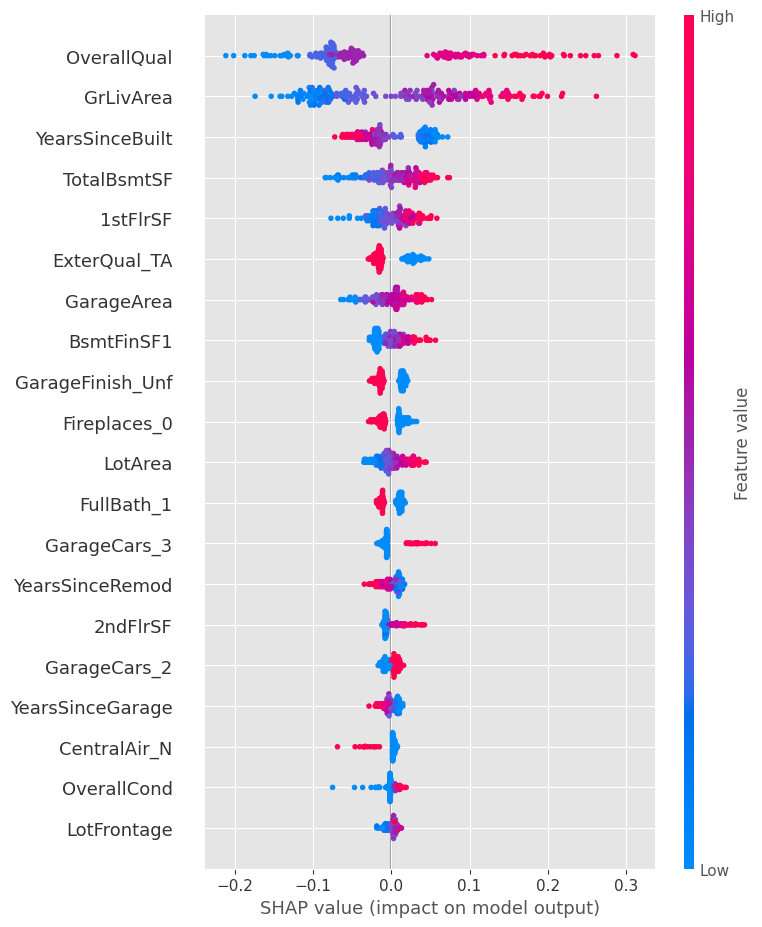

  0%|          | 0/200 [00:00<?, ?it/s]

Valeurs SHAP pour le Ridge


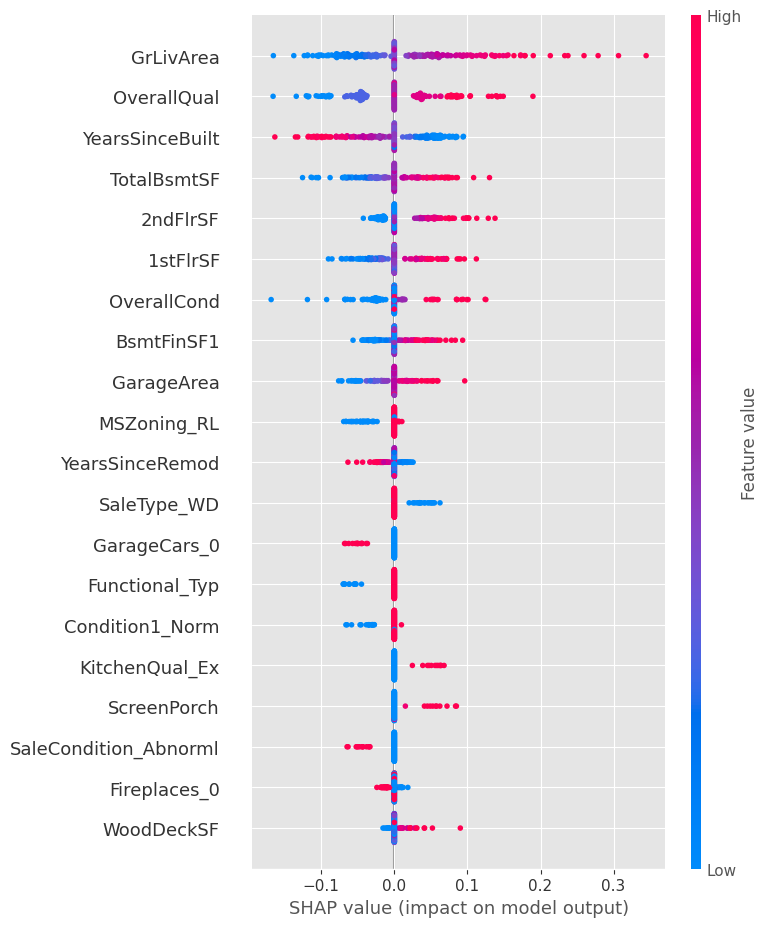

Valeurs SHAP pour le XGBoost


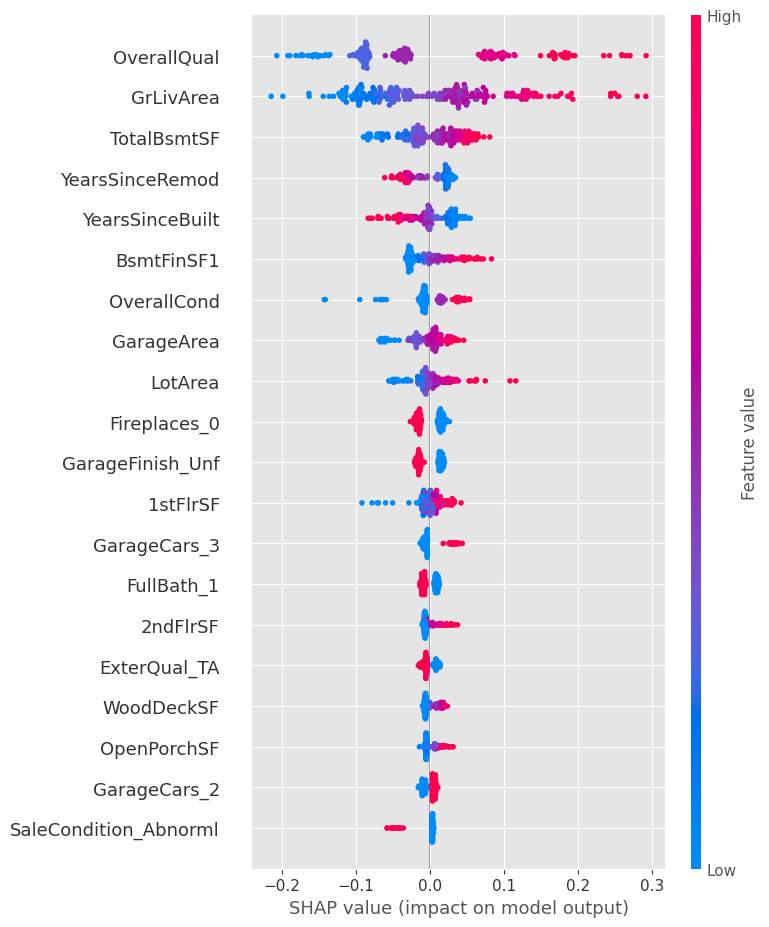

In [43]:
preprocessing_pipeline.fit(X_train)

X_sample = preprocessing_pipeline.transform(X.iloc[:200])

num_features = quantitative
cat_features = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(qualitative)
date_features = ['YearsSinceBuilt', 'YearsSinceRemod', 'YearsSinceGarage']

all_features = list(num_features) + list(cat_features) + list(date_features)

best_rf = joblib.load("best_random_forest_model.pkl")
best_xgboost = joblib.load("best_XGBoost_model.pkl")
best_ridge = joblib.load("best_Ridge_model.pkl")

explainer = shap.TreeExplainer(best_rf)
shap_values_rf = explainer.shap_values(X_sample)
print("Valeurs SHAP pour le Random Forest")
shap.summary_plot(shap_values_rf, X_sample, feature_names=all_features)

background = X_sample[:50]
explainer = shap.KernelExplainer(best_ridge.predict, background)
shap_values_ridge = explainer.shap_values(X_sample)
print("Valeurs SHAP pour le Ridge")
shap.summary_plot(shap_values_ridge, X_sample, feature_names=all_features)

explainer = shap.TreeExplainer(best_xgboost)
shap_values_xgb = explainer.shap_values(X_sample)
print("Valeurs SHAP pour le XGBoost")
shap.summary_plot(shap_values_xgb, X_sample, feature_names=all_features)


Grâce à l'analsye SHAP, nous pouvons voir quelles variables ont les plus d'impact sur le prix de vente en fonction des modèles. Nous avons écarté le Random Forest plus tôt et nous allons donc nous concenter sur le Ridge et le XGBoost. 

In [44]:
# Moyenne absolue des valeurs SHAP pour chaque feature
mean_abs_shap_ridge = np.abs(shap_values_ridge).mean(axis=0)
mean_abs_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)

# Top 10 features pour chaque modèle
top10_ridge = pd.Series(mean_abs_shap_ridge, index=all_features).sort_values(ascending=False).head(10)
top10_xgb = pd.Series(mean_abs_shap_xgb, index=all_features).sort_values(ascending=False).head(10)

# Fusionner dans un tableau comparatif
comparatif = pd.DataFrame({
    "Ridge (importance)": top10_ridge,
    "XGBoost (importance)": top10_xgb
}).fillna("")

comparatif

,Ridge (importance),XGBoost (importance)
1stFlrSF,0.023318,
2ndFlrSF,0.023683,
BsmtFinSF1,0.015068,0.022077
Fireplaces_0,,0.015721
GarageArea,0.013024,0.016646
GrLivArea,0.062904,0.081481
LotArea,,0.016007
MSZoning_RL,0.009247,
OverallCond,0.01752,0.019037
OverallQual,0.046909,0.101645


### Critères de choix entre Ridge et XGBoost à partir de l'analyse SHAP

- **Cohérence avec l’expertise métier** : Dans les deux cas, les variables principales sont fortement liées à notre cas métier et sont facilement comprises et adoptées par le métier. En effet, les variables choisies pour notre baseline se retrouvent ici.
- **Simplicité et explicabilité** : Le modèle Ridge est basée sur une régression linéaire, il est donc plus simple à mettre en place et plus facile à expliquer et à auditer. Nous constatons que les performances sont assez proches (Score RMSE quasiement égaux). Il pourrait être préférable de séléctionner le Ridge vis-à-vis du XGBoost.
- **Capacité à capturer des relations complexes** : XGBoost peut modéliser des interactions non linéaires et des effets croisés entre variables. Cependannt, nous ne constatons pas de différences majeures de performance entre les deux modèles. Par conséquent, il est difficile de justifier l'utilisation d'un modèle plus complexe.

**En résumé :**
Nous allons donc privilégier l'utilisation de la regression de Ridge car le modèle est plus simple pour des performances similaires.

## 4. Phase de Déploiement : Entraînement final et Prédiction

In [49]:
def evaluate_final_cv(model_name, model_class, best_params, preprocessing_pipeline, X, y, cv=10, scoring='neg_root_mean_squared_error'):
    model = model_class(**best_params, random_state=42)

    pipeline = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])

    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    mean_rmse = -scores.mean()
    std_rmse = scores.std()

    print(f"\nÉvaluation finale (cv 10) pour {model_name} :")
    print(f"RMSE moyen : {mean_rmse:.5f}")
    print(f"Écart-type : {std_rmse:.5f}")
    print("------------------------------------")
    
    return mean_rmse, std_rmse, -scores

evaluate_final_cv("Random Forest", RandomForestRegressor, random_forest_best_params, preprocessing_pipeline, X_train, y_train)
evaluate_final_cv("Ridge", Ridge, ridge_best_params, preprocessing_pipeline, X_train, y_train)
evaluate_final_cv("XGBoost", xgb.XGBRegressor, xgboost_best_params, preprocessing_pipeline, X_train, y_train)


Évaluation finale (cv 10) pour Random Forest :
RMSE moyen : 0.13041
Écart-type : 0.01360
------------------------------------

Évaluation finale (cv 10) pour Ridge :
RMSE moyen : 0.11156
Écart-type : 0.01437
------------------------------------

Évaluation finale (cv 10) pour XGBoost :
RMSE moyen : 0.11396
Écart-type : 0.01536
------------------------------------


(np.float64(0.11396399800139101),
 np.float64(0.01535561842292534),
 array([0.11534585, 0.09522084, 0.10470813, 0.13306847, 0.13941818,
        0.10504741, 0.1232967 , 0.09677818, 0.09848645, 0.12826978]))

In [50]:
print("\n--- Entraînement du modèle final Ridge sur l'ensemble des données d'entraînement ---")

# Utiliser les meilleurs hyperparamètres trouvés pour Ridge
final_model = Ridge(**ridge_best_params, random_state=42)
final_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', final_model)
])
final_pipeline.fit(X_train, y_train)
print("Entraînement terminé.")

log_predictions = final_pipeline.predict(X_test)

final_predictions = np.expm1(log_predictions)


submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})
submission.to_csv('submission_optimized_ridge.csv', index=False)

print("\nFichier 'submission_optimized_ridge.csv' généré avec succès.")
print("Aperçu des prédictions :")
print(submission.head())

# Sauvegarder le pipeline complet pour une utilisation future
import joblib
joblib.dump(final_pipeline, "final_ridge_pipeline.pkl")
print("Pipeline Ridge sauvegardé sous 'final_ridge_pipeline.pkl'")


--- Entraînement du modèle final Ridge sur l'ensemble des données d'entraînement ---
Entraînement terminé.

Fichier 'submission_optimized_ridge.csv' généré avec succès.
Aperçu des prédictions :
     Id      SalePrice
0  1461  119045.090918
1  1462  157091.690101
2  1463  181836.840513
3  1464  200968.174847
4  1465  191717.783076
Pipeline Ridge sauvegardé sous 'final_ridge_pipeline.pkl'


Nous loggons par conséquent le modèle final vers MLFlow dans une autre "experiment" afin de garder une trace du modèle de production

In [51]:
import mlflow.data


final_pipeline = joblib.load("final_ridge_pipeline.pkl")

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("House_Prices_Predictions_Production")

input_example = train_df.head(5)
signature = infer_signature(train_df, final_pipeline.predict(train_df))

with mlflow.start_run(run_name="Ridge_Final_Model"):
    mlflow.log_params(ridge_best_params)
    mlflow.sklearn.log_model(
        final_pipeline,
        name="model",
        input_example=input_example,
        signature=signature
    )

    mlflow.set_tag("model_name", "final_ridge_pipeline")
    input_dataset = mlflow.data.from_pandas(train_df, source="train.csv")
    mlflow.log_input(input_dataset, context="training")
    print("Pipeline Ridge loggé dans MLflow avec succès.")

Pipeline Ridge loggé dans MLflow avec succès.
🏃 View run Ridge_Final_Model at: http://localhost:5000/#/experiments/472951656940009004/runs/540b30ce35294815823cb0e289a72231
🧪 View experiment at: http://localhost:5000/#/experiments/472951656940009004


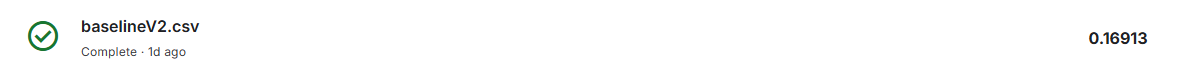

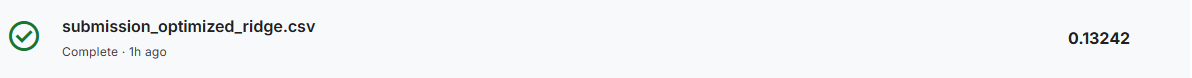

Nous avons donc exporté le modéle entrainé sur notre dataset, nous allons le déployer sur MLFlow afin de pouvoir l'interroger via une API REST. Un serveur MLFlow sera alors mis en place dans nos locaux et une petite applicaton web permettra d'interroger le modèle.

Les données seront alors renseignées dans un formulaire par le client et soumises au modèle. Une fois le prix de vente prédit, nos collaborateurs utiliseront cette informations afin de définir si le prix de ventes défini par le vendeur ne dépasse pas d'au maximum 5% le prix de vente prédits. 

Cet outil nous permettra donc d'écarter plus facilement les prêts à "risques" car nous aurons une assurance que la valeur du bien immobilier correspond au prix de vente.

Nous n'avons pas besoin que le modèle soit réentrainé de manière continue ni qu'il soit disponible 24/24 7/7. Nous allons donc le réentrainer chaque année lors de la révision des taux hypothécaires et nous pourrons déployer le nouveau modèle hors des heures de bureau. Nous utiliserons les données de l'année précédente (les mêmes que celles utilisées pour calculer les taux hypothécaires).

Afin de vérifier que le modèle reste en adéquation avec la réalité, une fois par mois, nous contrôlerons les résultats fournis par le modèle sur des ventes effectuées. Nous accepterons un écart maximal 5% entre la prédiction et la réalité de la vente. De plus, nous mettrons en place un système d'audits géré par un organe de révision externe afin de s'assurer de l'impartialité du modèle.

## Cadre juridique et éthique appliqué au projet Banklytics

### Référentiels réglementaires mobilisés
Bien que le projet soit ancré dans un contexte nord-américain, sa conception s’appuie volontairement sur les référentiels européens, en particulier le Règlement sur l’intelligence artificielle (AI Act) et le Règlement général sur la protection des données (RGPD). Cette approche permet d’anticiper les exigences internationales en matière de gouvernance algorithmique et de garantir un haut niveau de conformité, notamment en cas d’extension du modèle à d’autres juridictions.

### Gouvernance des données
Les données utilisées sont extraites d’anciens dossiers techniques de prêts hypothécaires, comprenant uniquement des caractéristiques factuelles des biens immobiliers (surface, nombre de pièces, année de construction, qualité générale, etc.). Aucune information personnelle ou sensible concernant les emprunteurs n’est incluse. L’ensemble du jeu de données est anonymisé, consolidé et nettoyé, conformément aux principes du RGPD, afin de garantir la protection des données et la qualité statistique du modèle.

### Prévention des biais et équité
Certaines variables, telles que la localisation (quartier), sont identifiées comme potentiellement sensibles en raison de leur corrélation possible avec des inégalités socio-économiques. Des analyses exploratoires ont permis de surveiller ces variables et d’anticiper d’éventuels biais indirects. Un mécanisme de monitoring post-déploiement est prévu afin de détecter toute dérive ou discrimination systématique sur des segments spécifiques (zones géographiques, types de biens).

### Explicabilité et supervision humaine
Le modèle est conçu pour fonctionner comme un outil d’aide à la décision, sans automatiser l’acceptation ou le refus d’un crédit. Chaque estimation est accompagnée d’une visualisation des facteurs explicatifs, grâce à l’outil SHAP, permettant à l’analyste de comprendre les variables ayant influencé la prédiction. Ce principe d’explicabilité répond aux exigences de l’article 13 du RGPD et aux recommandations de l’article 14 de l’AI Act sur la supervision humaine des systèmes à haut risque.

### Auditabilité et cycle de vie du modèle
Conformément aux articles 9 à 15 de l’AI Act, le modèle fait l’objet d’une documentation rigoureuse, incluant la version des jeux de données, les hyperparamètres d’apprentissage, les performances historiques (RMSLE), ainsi que les résultats des tests de robustesse. Un retraining trimestriel est prévu avec les nouvelles données validées, accompagné d’un suivi mensuel des performances pour détecter d’éventuelles dérives (concept drift).

## Conclusion

Ce notebook a appliqué une démarche robuste et moderne :

1. Utilisation d'un pipeline Scikit-Learn pour un prétraitement propre et reproductible.
2. Optimisation automatisée des hyperparamètres avec Optuna pour maximiser la performance.
3. Entraînement d'un modèle final performant et génération des prédictions.
4. Analyse de l'importance des variables pour une meilleure explicabilité du modèle.

Le modèle est prêt à être intégré comme outil d'aide à la décision pour les analystes de Banklytics.